In [1]:
import os
import sys
import numpy as np
import torch
import gym

sys.path.append("../../")
sys.path.append("../../../libfastsim/build/")
from nosalro.env import SimpleEnv
from nosalro.robots import Point
from nosalro.vae import StatesDataset, VariationalAutoencoder, Scaler, train, visualize
from nosalro.rl import learn

/home/tsak/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
np.savetxt(X=np.random.uniform(low=0, high=600, size=(100000, 2)), fname="../../data/test.dat")
dataset = StatesDataset(path="../../data/test.dat")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = Scaler('standard')
scaler.fit(dataset.get_data())
dataset.scale_data(scaler)
vae_arch = VariationalAutoencoder(2, 2, scaler=scaler, hidden_sizes=[128, 64]).to(device)

In [18]:
epochs = 500
lr = 3e-4
vae = train(
    vae_arch,
    epochs,
    lr,
    dataset,
    device,
    beta = 10,
    file_name='../../models/vae_models/vae_random_points_pdp_only_kl.pt',
    overwrite=True,
    weight_decay=0,
    batch_size = 512,
)

Epoch: 0:  | Gaussian NLL -> -3.087  | KL Div -> 17.306  | Total loss -> -3.087
Epoch: 1:  | Gaussian NLL -> -3.899  | KL Div -> 17.000  | Total loss -> -3.899
Epoch: 2:  | Gaussian NLL -> -4.247  | KL Div -> 17.040  | Total loss -> -4.247
Epoch: 3:  | Gaussian NLL -> -3.727  | KL Div -> 17.243  | Total loss -> -3.727
Epoch: 4:  | Gaussian NLL -> -3.897  | KL Div -> 17.199  | Total loss -> -3.897
Epoch: 5:  | Gaussian NLL -> -3.642  | KL Div -> 17.529  | Total loss -> -3.642
Epoch: 6:  | Gaussian NLL -> -3.997  | KL Div -> 17.259  | Total loss -> -3.997
Epoch: 7:  | Gaussian NLL -> -3.712  | KL Div -> 17.382  | Total loss -> -3.712
Epoch: 8:  | Gaussian NLL -> -3.915  | KL Div -> 17.268  | Total loss -> -3.915
Epoch: 9:  | Gaussian NLL -> -3.631  | KL Div -> 17.396  | Total loss -> -3.631
Epoch: 10:  | Gaussian NLL -> -3.956  | KL Div -> 17.317  | Total loss -> -3.956
Epoch: 11:  | Gaussian NLL -> -3.728  | KL Div -> 17.448  | Total loss -> -3.728
Epoch: 12:  | Gaussian NLL -> -3.868  

KeyboardInterrupt: 

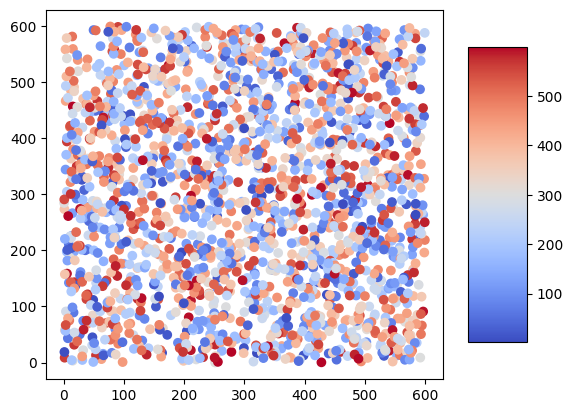

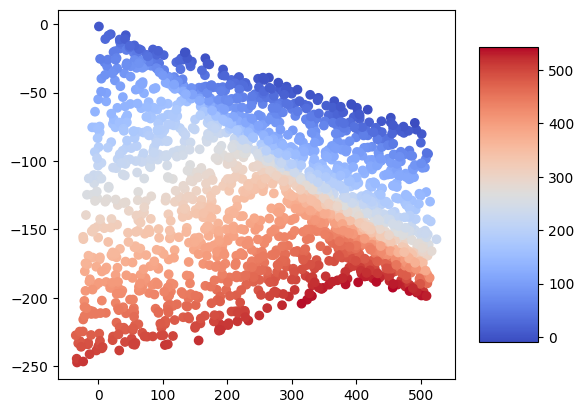

In [12]:
visualize(dataset.get_data(), projection='2d')
visualize(vae(torch.tensor(dataset.get_data()).to(device), device, True, False)[0].detach().cpu().numpy(), projection='2d')

In [16]:
robot = Point([10, 10])
action_space = gym.spaces.Box(low=-1., high=1., shape=(2,), dtype=np.float32)
observation_space = gym.spaces.Box(
    low=np.array([0, 0, -np.inf, -np.inf]),
    high=np.array([600, 600, np.inf, np.inf]),
    shape=(4,),
    dtype=np.float32
)

/home/tsak/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [17]:
env = SimpleEnv(
    robot=robot,
    reward_type='mse',
    target=None,
    n_obs=2,
    goals=dataset.get_data()[[8000, 200]],
    goal_conditioned_policy=True,
    latent_rep=True,
    observation_space=observation_space,
    action_space=action_space,
    random_start=True,
    max_steps=0,
    vae=vae,
    scaler=scaler
)